## Working with Ocean (POP) data

This notebook targets comparing CESM POP data in its original form to CESM POP data that has undergone lossy compression (meaning that the reconstructed file is not exactly equivalent to the original file). The tools provided in ldcpy are intended to highlight differences due to compression artifacts in order to assist scientist in evaluating the amount of lossy compression to apply to their data.

The POP data used here are NetCDF files in "timeseries" file format, meaning that each NetCDF file contains one (major) output variable.

 We recommend going through the tutorial notebook before this one (as it contains more introductory material).

In [1]:
# Add ldcpy root to system path
import sys

sys.path.insert(0, '../../../')
# Import ldcpy package
import ldcpy

# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# display the plots in this notebook
%matplotlib inline

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")

Load the sample POP data: SSH (sea surface height) and SST (sea surface temperature)

In [2]:
# SST (orig + 3 variants) - 100 days of daily data
pop_sst = ldcpy.open_datasets(
    ["SST"],
    [
        '../../../data/pop/pop.SST.100days.nc',
        '../../../data/pop/zfp1.0.pop.SST.100days.nc',
        '../../../data/pop/zfp1e-1.pop.SST.100days.nc',
        '../../../data/pop/zfp1e-2.pop.SST.100days.nc',
    ],
    ['orig', 'zfp1.0', 'zfp1e-1', 'zfp1e-2'],
)
# SSH (orig + 3 variants) - 12 months of monthly averages
pop_ssh = ldcpy.open_datasets(
    ["SSH"],
    [
        '../../../data/pop/pop.SSH.12mon.nc',
        '../../../data/pop/zfp1.0.pop.SSH.12mon.nc',
        '../../../data/pop/zfp1e-1.pop.SSH.12mon.nc',
        '../../../data/pop/zfp1e-2.pop.SSH.12mon.nc',
    ],
    ['orig', 'zfp1.0', 'zfp1e-1', 'zfp1e-2'],
)

dataset size in GB 0.20

dataset size in GB 0.03



### Comparing the data
First we compare some of the single number statistics.

In [3]:
# Look at the first time slice for SST
sst_t0 = pop_sst.isel(time=0)
ldcpy.compare_stats(sst_t0, 'SST', 'orig', 'zfp1e-1')

 
mean orig                          : 16.593
mean zfp1e-1                       : 16.592
mean diff                          : 0.0016582
 
variance orig                      : 117.39
variance zfp1e-1                   : 117.38
 
standard deviation orig            : 10.835
standard deviation zfp1e-1         : 10.834
 
max value orig                     : 30.528
max value zfp1e-1                  : 30.523
min value orig                     : -2.1639
min value zfp1e-1                  : -2.1562
 
max abs diff                       : 0.036346
min abs diff                       : 0
mean abs diff                      : 0.0080806
mean squared diff                  : 2.7496e-06
root mean squared diff             : 0.010033
normalized root mean squared diff  : 0.00030689
normalized max pointwise error     : 0.0011118
pearson correlation coefficient    : 1
ks p-value                         : 3.0283e-23
spatial relative error(% > 0.0001) : 87.395
max spatial relative error         : 1
ssim      

In [4]:
# Look at the first time slice for SSH
ssh_t0 = pop_ssh.isel(time=0)
ldcpy.compare_stats(ssh_t0, 'SSH', 'orig', 'zfp1e-1')

 
mean orig                          : -10.851
mean zfp1e-1                       : -10.851
mean diff                          : 7.4278e-05
 
variance orig                      : 5719.4
variance zfp1e-1                   : 5719.3
 
standard deviation orig            : 75.627
standard deviation zfp1e-1         : 75.627
 
max value orig                     : 150.47
max value zfp1e-1                  : 150.47
min value orig                     : -195.38
min value zfp1e-1                  : -195.38
 
max abs diff                       : 0.037424
min abs diff                       : 0
mean abs diff                      : 0.0085802
mean squared diff                  : 5.5173e-09
root mean squared diff             : 0.010611
normalized root mean squared diff  : 3.068e-05
normalized max pointwise error     : 0.00010821
pearson correlation coefficient    : 1
ks p-value                         : 1
spatial relative error(% > 0.0001) : 62.514
max spatial relative error         : 10.784
ssim       

If we don't want the whole list of statistics, we can get the metrics objects and request a specific metric. This requires more lines of code, but could be useful in some situations.

In [5]:
# For SST, just get the. mean and std of the original data at the first time slice
sst_orig = pop_sst["SST"].sel(collection="orig").isel(time=0).compute()
sst_orig_m = ldcpy.metrics.DatasetMetrics(sst_orig, aggregate_dims=['nlat', 'nlon'])

sst_orig_mean = sst_orig_m.get_metric('mean')
print('mean = ', sst_orig_mean.data)

sst_orig_std = sst_orig_m.get_metric('std')
print('std = ', sst_orig_std.data)

mean =  16.593348213017695
std =  10.834812433986492


In [6]:
# For SST, just get the. mean and std of the "zfp1.0" data at the first time slice
sst_zfp = pop_sst["SST"].sel(collection="zfp1.0").isel(time=0).compute()
sst_zfp_m = ldcpy.metrics.DatasetMetrics(sst_zfp, aggregate_dims=['nlat', 'nlon'])

sst_zfp_mean = sst_zfp_m.get_metric('mean')
print('mean = ', sst_zfp_mean.data)

sst_zfp_std = sst_zfp_m.get_metric('std')
print('std = ', sst_zfp_std.data)

mean =  16.57264649932724
std =  10.815969674661007


In [7]:
# For SST, get a single "diff" metric: ssim at t=0
# (note that a diff metric requires 2 sets of dataa)
sst_orig = pop_sst["SST"].sel(collection="orig").isel(time=0).compute()
sst_zfp = pop_sst["SST"].sel(collection="zfp1.0").isel(time=0).compute()
sst_diff_m = ldcpy.metrics.DiffMetrics(sst_orig, sst_zfp, aggregate_dims=['nlat', 'nlon'])

sst_ssim = sst_diff_m.get_diff_metric('ssim')
print('ssim = ', sst_ssim)

ssim =  0.9925994932337026


### Plotting the data

The main difference in plotting ocean data (vs. the atmosphere data in the tutorial notebook) is that the land masses are greyed out. Note that because data in POP over land contains Nans and the cartopy maps does not quite line up with the POP grid near Antartica, areas of NaNs are visible in the plot near the coatline of Antartica.

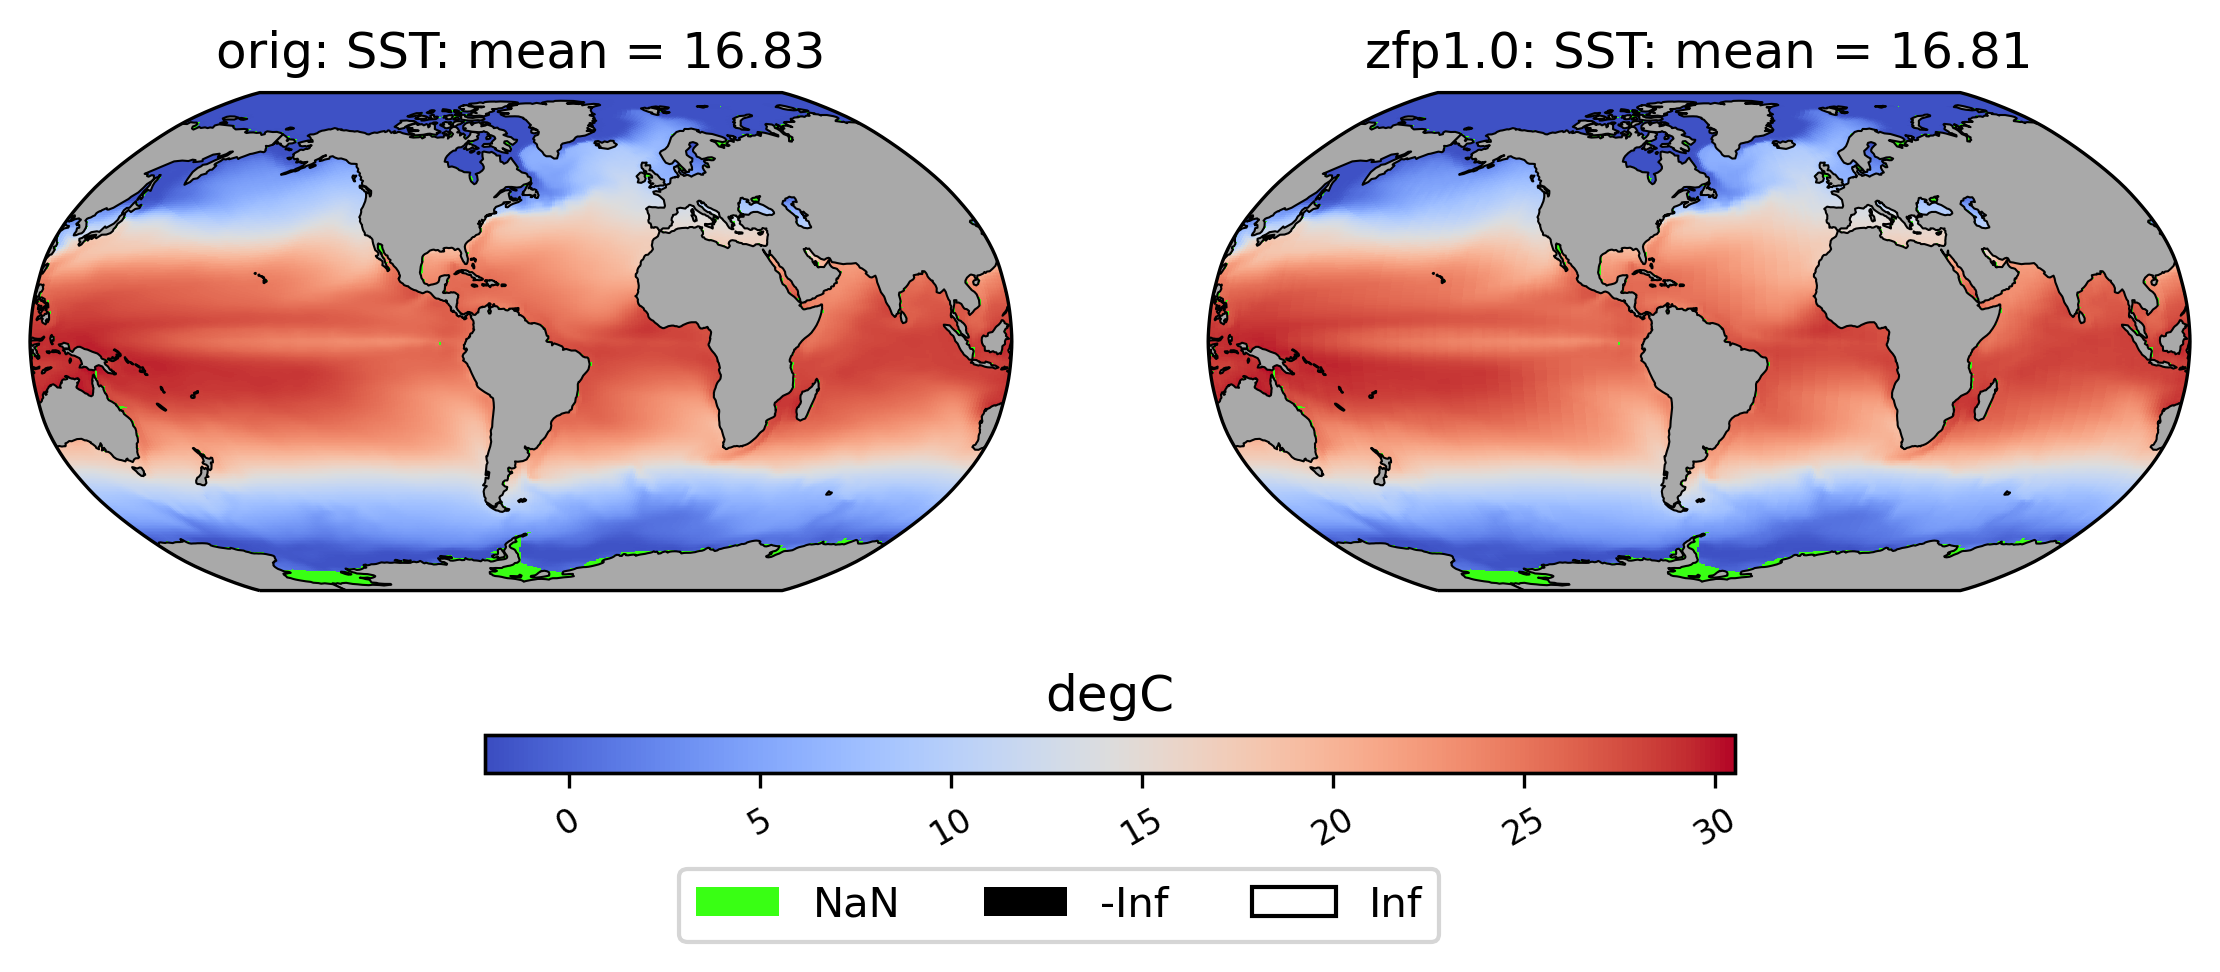

In [11]:
# Let's compare the mean (over time) for the SST witha compressed variant)
ldcpy.plot(pop_sst, "SST", sets=["orig", "zfp1.0"], calc="mean", plot_type="spatial")

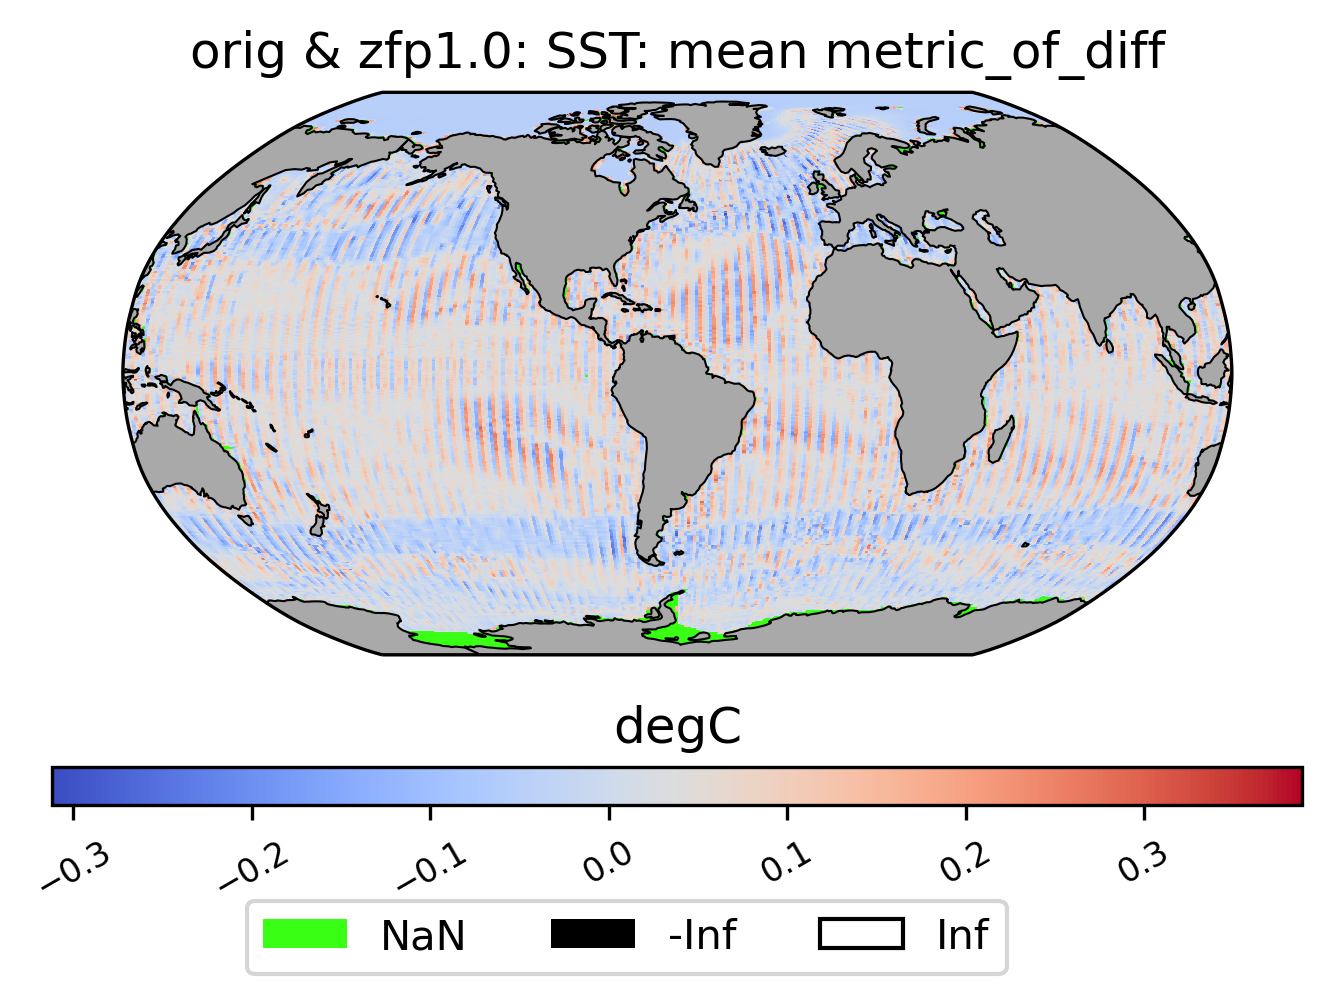

In [12]:
# Same ocmparion as above, but just viewing the difference
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0"],
    calc="mean",
    calc_type="metric_of_diff",
    plot_type="spatial",
)

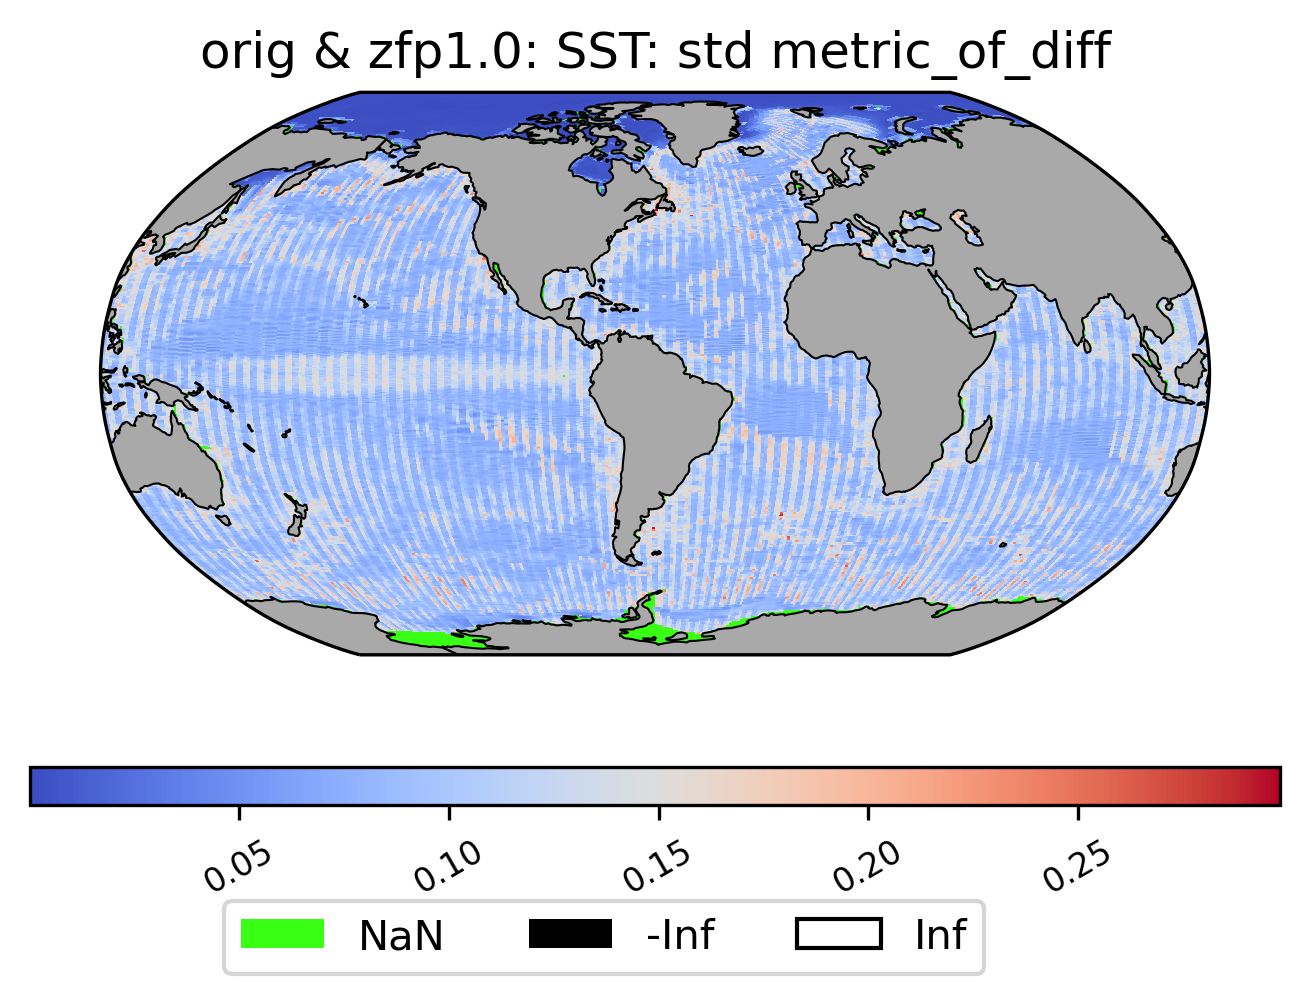

In [13]:
# We can also compare the difference in std
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0"],
    calc="std",
    calc_type="metric_of_diff",
    plot_type="spatial",
)

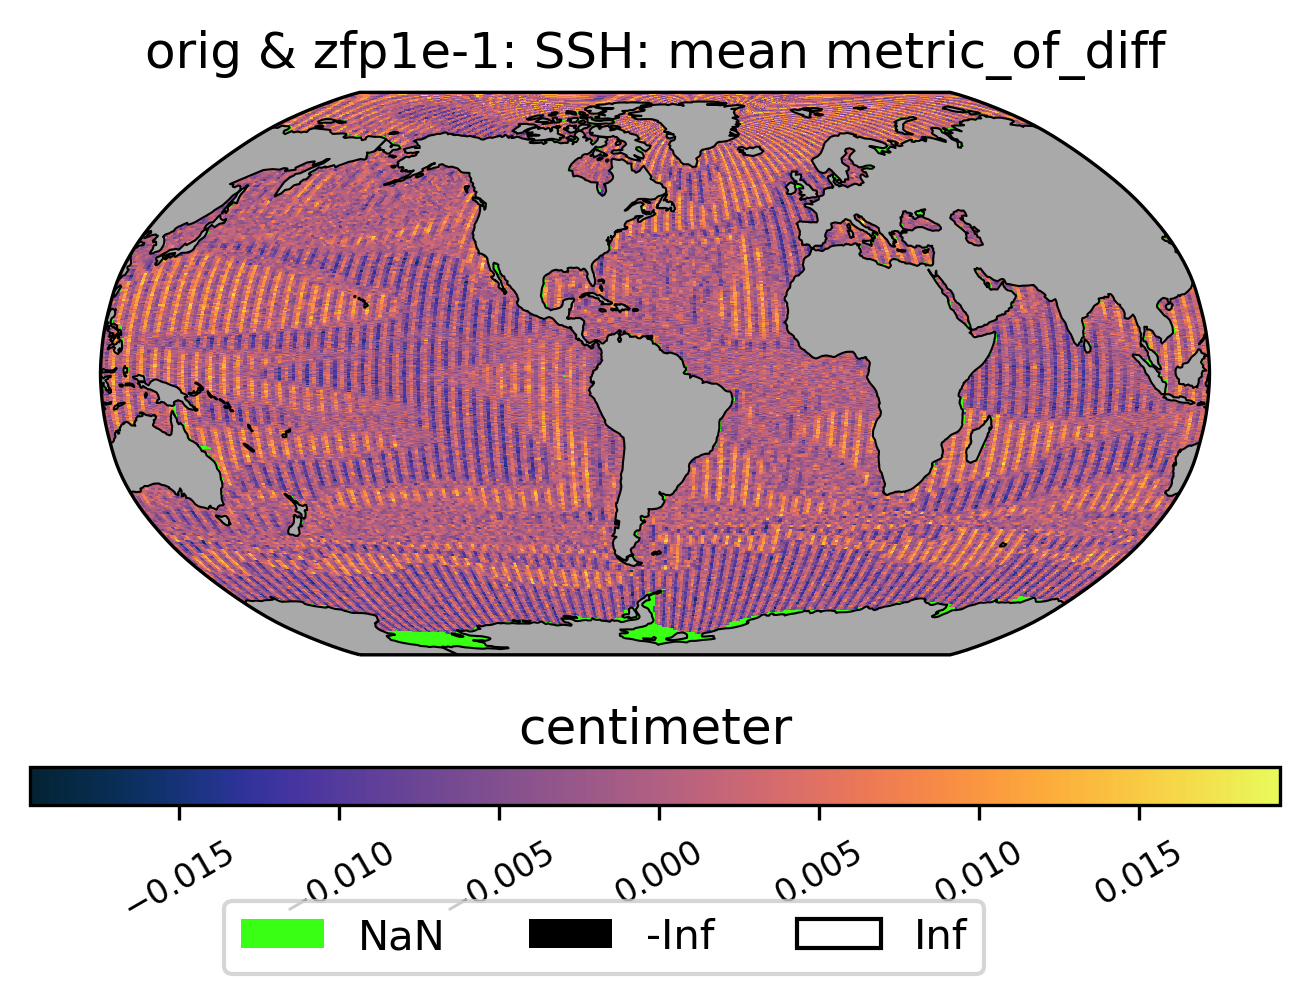

In [14]:
# Here we look at SSH - the differencee in mean
ldcpy.plot(
    pop_ssh,
    "SSH",
    sets=["orig", "zfp1e-1"],
    calc="mean",
    calc_type="metric_of_diff",
    plot_type="spatial",
    color="cmo.thermal",
)

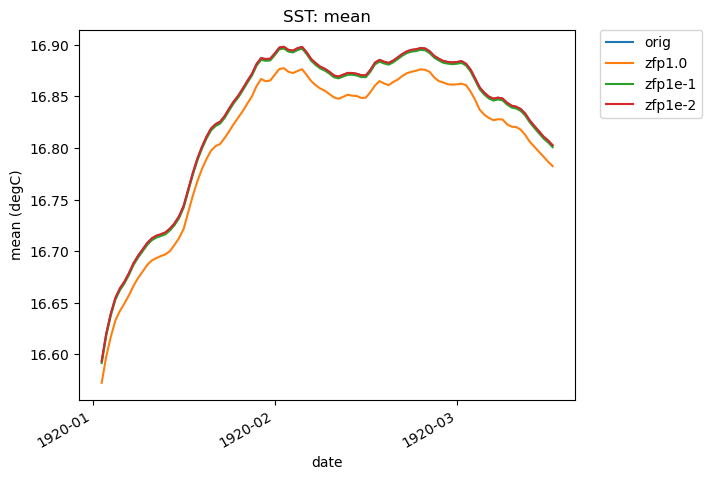

In [15]:
# Time-series plot of SST and the three compressed variants
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0", "zfp1e-1", "zfp1e-2"],
    calc="mean",
    plot_type="time_series",
)

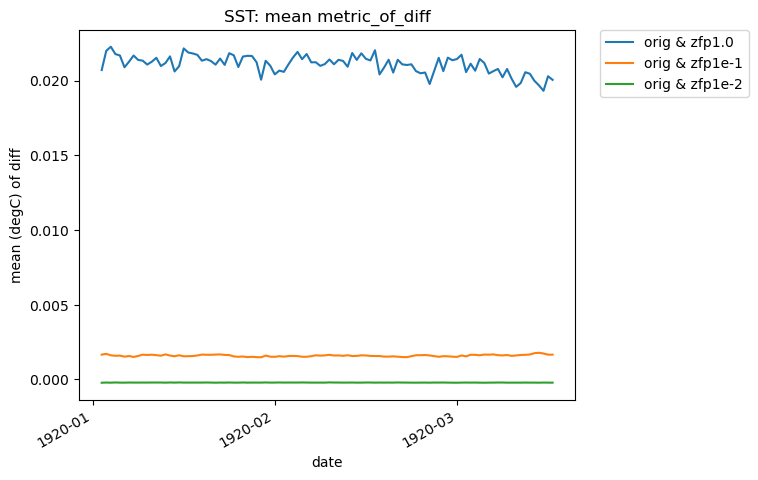

In [16]:
# We can also look at differences in a timeseries
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0", "zfp1e-1", "zfp1e-2"],
    calc="mean",
    plot_type="time_series",
    calc_type="metric_of_diff",
)

In [18]:
# Time series at a point
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig"],
    calc="mean",
    plot_type="time_series",
    lat=44.76,
    lon=-123.75,
)

UnboundLocalError: local variable 'lat_dim' referenced before assignment